In [1]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:90% !important;}
div.cell.code_cell.rendered{width:100%;}
div.input_prompt{padding:0px;}
div.CodeMirror {font-family:Consolas; font-size:12pt;}
div.text_cell_render.rendered_html{font-size:12pt;}
div.output {font-size:12pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:12pt;}
div.prompt {min-width:70px;}}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:12pt;padding:5px;}
table.dataframe{font-size:12px;}
</style>
"""))

<b><font size="6" color="#009e84"> ch04. 머신러닝 모형 최적화</font></b>

# 1절. 변수 선택과 차원 축소

## 1-1 변수선택과 차원축소

- 종속변수에 영향을 주는 변수들을 찾아 학습에 사용할 독립변수의 수를 줄임<br>(어떻게 하면 score를 높일 수 있을지?)
- 과적합과 변수들 사이의 다중공선성(변수들간 강한 상관관계)을 줄일 수 있음
    * 회귀계수 해석이 어려워짐. 모델 예측력이 좋아도 해석력이 떨어짐(어떤 변수가 제일 큰 요인인지 잘), p값이나 유의성 검정이 왜곡될 수 있음
- 모형의 학습 시간을 줄일 수 있음
- 주성분분석, 상관분석, **분류모형의 feature_importance_, 예측 모형의 coef_**
- SelectKBest : 가장 높은 score에 따라 K개의 특징을 선택

## 1-2 주성분분석(PCA, Principal Component Anaysis)
- 주성분분석은 변수 선택 및 차원축소 방법(기존의 모든 변수를 조합하여 새로운 변수로 만듦) 으로 널리 사용
- 주성분 분석은 상관관계가 있는 변수들을 선형결합해서 **분산이 극대화된 상관관계가 없는 새로운 변수(주성분)들로 축약**하는 것
- 주성분 분석은 사실 선형대수학이라기보다는 선형대수학의 활용적인 측면이 강하며 영상인식, 통계 데이터분석(주성분 찾기), 데이터 압축, 노이즈제거 등 여러 분야에 사용
- 영상처리에서 많이 활용 : 여러개의 영상 중 대표 이미지를 찾을 때 활용

In [3]:
import seaborn as sns

iris = sns.load_dataset('iris')
iris_X, iris_y = iris.iloc[:, :-1], iris.species
iris_X.shape, iris_y.shape

((150, 4), (150,))

In [15]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2) # n_components=n : 주성분 갯수
# pca.fit(iris_X)
# pca.transform(iris_X)
iris_pca = pca.fit_transform(iris_X)
iris_pca[:3] # 뽑혀진 주성분 2개

array([[-2.68412563,  0.31939725],
       [-2.71414169, -0.17700123],
       [-2.88899057, -0.14494943]])

In [12]:
iris_X.head(3) # 원래 이런 데이터를 저렇게 바꾼것

,sepal_length,sepal_width,petal_length,petal_width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2


In [16]:
import pandas as pd

pd.DataFrame(iris_pca, columns=['pca1','pca2']).corr() # 주성분 끼리의 상관관계

,pca1,pca2
pca1,1.000000e+00,3.722081e-16
pca2,3.722081e-16,1.000000e+00


In [17]:
# 설명분산 : 각 주성분이 데이터 분산을 잘 표현하는지 (정보량). 값이 클수록 더 중요한 주성분

pca.explained_variance_ # pca1, pca2

array([4.22824171, 0.24267075])

In [18]:
# 설명정도 : 0 ~ 1 사이의 비율로 조정된 값

pca.explained_variance_ratio_ # pca1이 92%, pca2가 5%. 그리고 두개를 합치면 97.7인데 그럼 2.3% 정도가 줄이면서 날아갔다는말

array([0.92461872, 0.05306648])

In [19]:
# 각 주성분의 계수 : 각 주성분이 원래 특성들과 어떤 관계가 있는지 나타내는 가중치
# pca1 = 0.36138659*sepal_length + -0.08452251*sepal_width + 0.85667061*petal_length + 0.3582892*petal_width
# pca2 = 0.65658877*sepal_length ~
pca.components_

array([[ 0.36138659, -0.08452251,  0.85667061,  0.3582892 ],
       [ 0.65658877,  0.73016143, -0.17337266, -0.07548102]])

In [20]:
iris_X.head()

,sepal_length,sepal_width,petal_length,petal_width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


## 1-3 상관관계 확인

- 각 변수들끼리 상관관계를 확인하고 시각화해서 종속변수와 상관관계가 높은 변수들만 선택

In [23]:
redwine = pd.read_csv('data/winequality-red.csv', sep=';')
# redwine = pd.read_csv('data/winequality-red.csv', delimiter=';') 이렇게도 가능
redwine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


cmap의 종류 : https://jrc-park.tistory.com/155 <br>
http://seaborn.pydata.org/generated/seaborn.heatmap.html#seaborn.heatmap <br>
http://seaborn.pydata.org/examples/many_pairwise_correlations.html

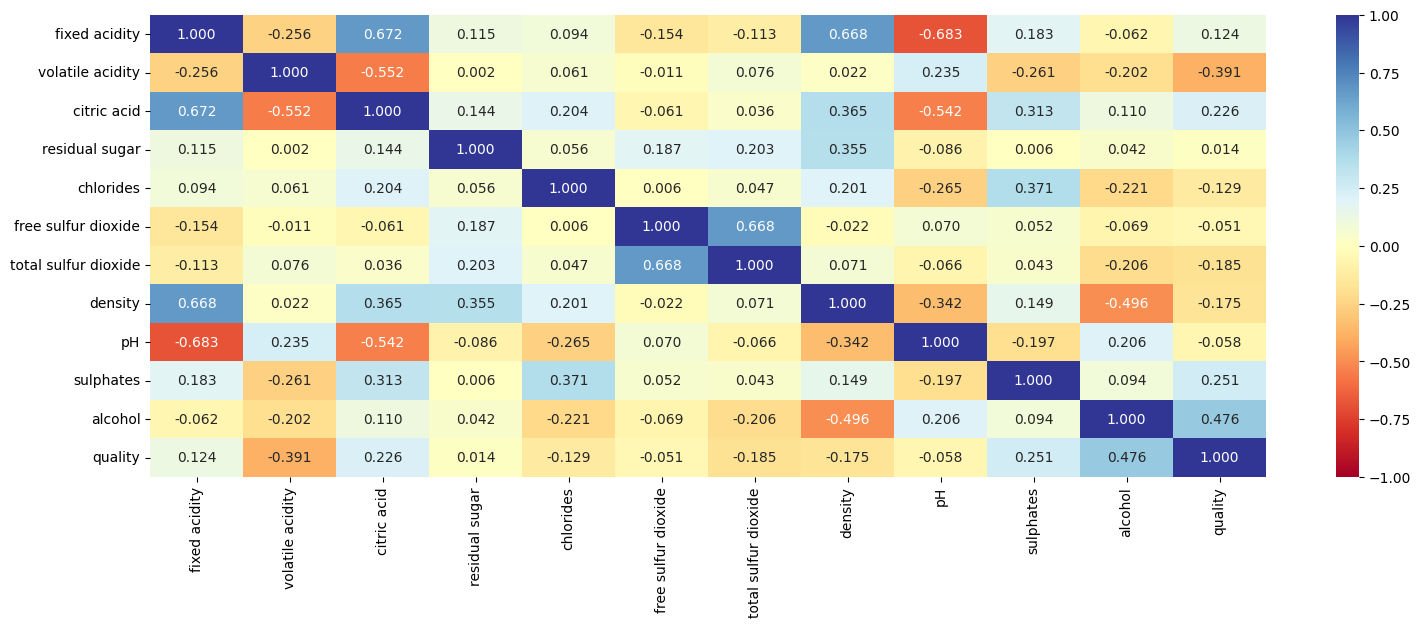

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(18,6))
corr = redwine.corr()
sns.heatmap(corr, annot=True, fmt='.3f', vmin=-1, vmax=1, cmap='RdYlBu')

plt.show()

In [51]:
import numpy as np

mask = np.tril(np.ones_like(corr))       # 대각선 포함하여 아래가 1
mask = np.tril(np.ones_like(corr), k=-1) # 대각선 제외하고 아래가 1
mask = np.triu(np.ones_like(corr))       # 대각선 포함하여 위가 1
mask

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

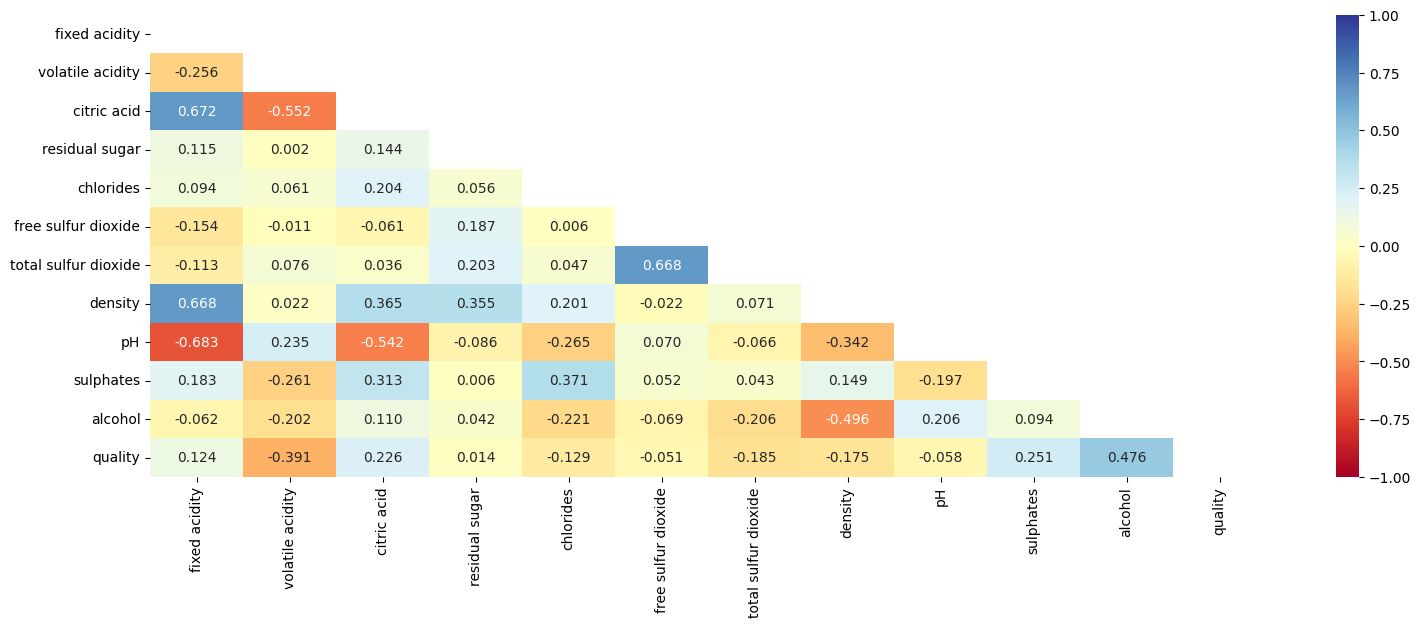

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(18,6))
corr = redwine.corr()
mask = np.triu(np.ones_like(corr))       # 대각선 포함하여 위가 1

sns.heatmap(corr, annot=True, fmt='.3f', vmin=-1, vmax=1, cmap='RdYlBu', mask=mask)

plt.show()

## 1-4 분류모형의 Feature Importance

- 분류모형의 feature_importances_ 속성 : 각 독립변수들이 종속변수에 영향을 주는 정도
- DecisionTreeClassifier, RandomForestClassifer, GradientBoostingClassifier..(tree계열)
- LogisticRegression, SVC, MLPclassifier등은 featuer_importances_속성 없음

In [59]:
from sklearn.model_selection import train_test_split

X = redwine.iloc[:, :-1]#.values # numpy 배열로
y = redwine.iloc[:, -1]#.to_numpy() # numpy 배열로
train_X, test_X, train_y, test_y = train_test_split(X,y, test_size=0.3, stratify=y)
train_X.shape, test_X.shape, train_y.shape, test_y.shape, type(train_X)

((1119, 11), (480, 11), (1119,), (480,), pandas.core.frame.DataFrame)

In [60]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=10, # 트리의 갯수 10
                                  random_state=10)
rf_model.fit(train_X, train_y)

RandomForestClassifier(n_estimators=10, random_state=10)

In [61]:
rf_model.score(test_X, test_y)

0.6625

In [62]:
rf_model.feature_importances_

array([0.07848441, 0.10278206, 0.08022244, 0.06337027, 0.07296841,
       0.07557095, 0.10363518, 0.08712693, 0.07261161, 0.10291772,
       0.16031004])

In [65]:
features = pd.DataFrame(np.c_[X.columns, rf_model.feature_importances_],
                        columns=['feature', 'importance'])
features['importance'].sum()

1.0

In [67]:
features.sort_values(by='importance', ascending=False, inplace=True)
features.reset_index(drop=True, inplace=True)
features
# features.set_index(drop=True, keys='feature') feature을 열이름으로

,feature,importance
0,alcohol,0.16031
1,total sulfur dioxide,0.103635
2,sulphates,0.102918
3,volatile acidity,0.102782
4,density,0.087127
5,citric acid,0.080222
6,fixed acidity,0.078484
7,free sulfur dioxide,0.075571
8,chlorides,0.072968
9,pH,0.072612


### feauture_importance_를 이용한 변수 중요도 시각화

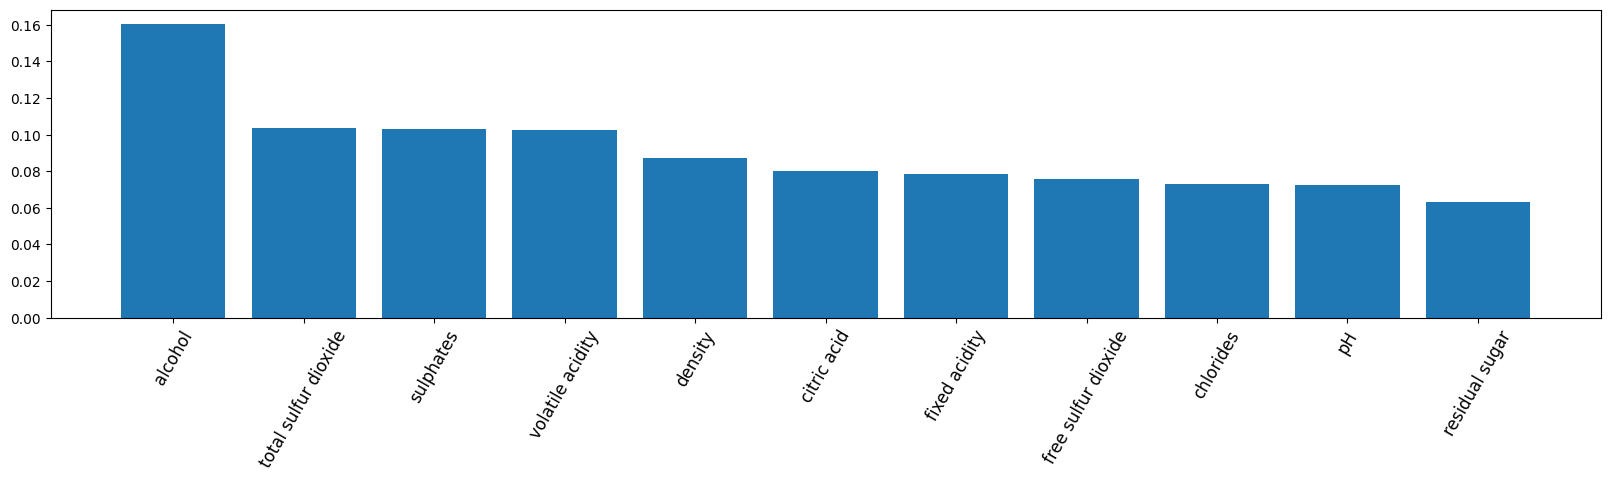

In [70]:
# features를 시각화

plt.figure(figsize=(20,4))
plt.bar(features.feature, features.importance)

plt.xticks(fontsize=12, rotation=60)
plt.show()

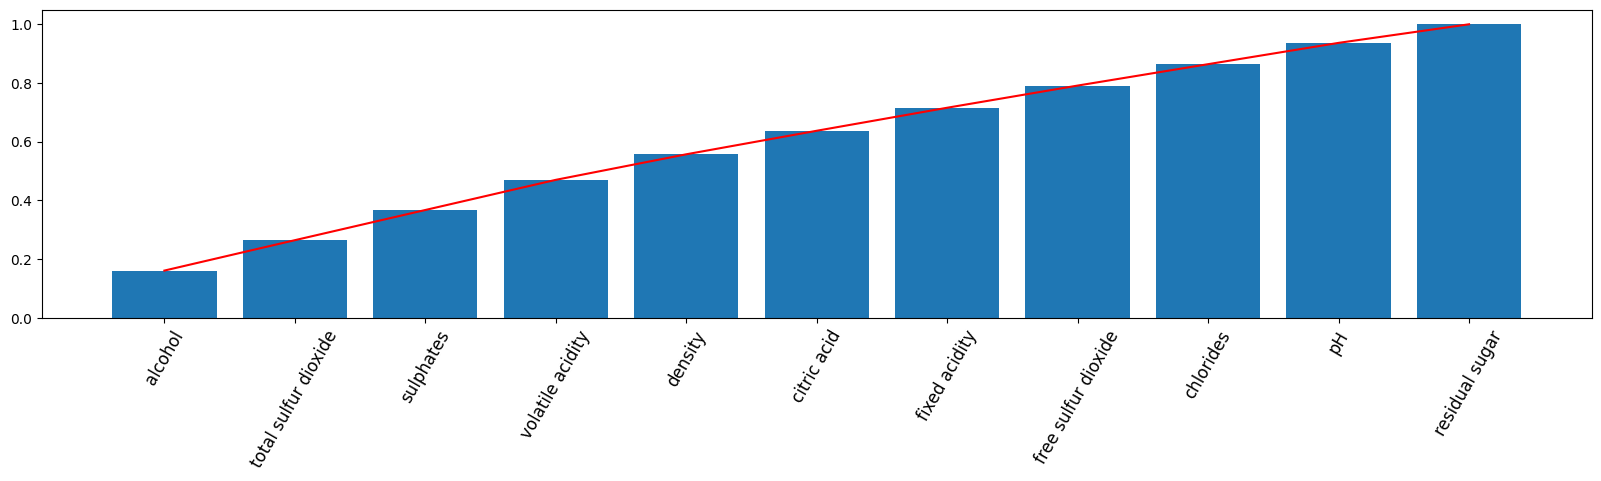

In [72]:
# 누적합을 이용한 시각화

y_stack = np.cumsum(features.importance)

plt.figure(figsize=(20,4))
plt.bar(features.feature, y_stack)
plt.plot(features.feature, y_stack, color='red')

plt.xticks(fontsize=12, rotation=60)
plt.show()

# 아래처럼 빨간선이 직선이면 차근차근 늘어나고 있다, 어느하나 버릴게 없다 라는말. 그런데 빨간선이 직선으로 올라가다 어느순간 수평을 이루며 거의 변화가 없어질때는 끊어주는것

### RFE(Recursive Feature Elimination) 방식

- RFE를 이용하면 중요도에 따라 중요도가 낮은 변수부터 하나씩 제거해 나가면서 최종적으로 선택한 변수를 찾는다

In [73]:
from sklearn.feature_selection import RFE

rfe_model = RFE(# RandomForestClassifier(n_estimators=10, random_state=10),
                rf_model,
                n_features_to_select=5
)

rfe_model.fit(train_X, train_y)
rfe_model.get_support() # 선택된 변수(True)인지 제거된 변수(False)인지 여부

array([False,  True, False, False, False, False,  True,  True, False,
        True,  True])

In [76]:
features_rfe = pd.DataFrame(np.c_[X.columns, rfe_model.get_support()], 
                            columns=['feature', 'selected'])
features_rfe[features_rfe['selected']==True]

,feature,selected
1,volatile acidity,True
6,total sulfur dioxide,True
7,density,True
9,sulphates,True
10,alcohol,True


## 1-5 SelectKBest

- 가장 높은 score에 따라 k개 특징변수 선택

In [82]:
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectKBest, f_classif, chi2

# f_classif : ANNOVA F검정 - 독립변수가 연속형(그룹간 차이가 유의미한지)
# chi2 : 카이제곱통계량 검정 - 독립변수가 범주형(타겟변수도 범주형) 또는 양의 실수

X,y = load_iris(return_X_y=True, as_frame=False)
X.shape, y.shape, y

X_new = SelectKBest(f_classif, k=1).fit_transform(X,y) # 대문자로 시작하지만 클래스 아님

In [83]:
X_new[:3] # 밑에 X를 보면 통계적으로 봤을때 ANNOVA 검정이 petal_length를 중요하다고 뽑은것. 그룹간 차이에서 가장 유의미한 결과를 가지고 있다라는말

array([[1.4],
       [1.4],
       [1.3]])

In [84]:
X[:3]

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2]])

# **<font color="red">2절. 파라미터 탐색</font>**

- 하이퍼파라미터(모델의 성능에 영향을 미칠 수 있는 사용자가 직접 설정하는 파라미터)
- 어떤 파라미터를 사용하는게 최적의 결과를 낼지 탐색
- sklearn 패키지의 하이퍼 파라미터 튜닝 도구
    - validation_curve() : 단일 하이퍼 파라미터 최적화 함수
    - GridSearchCV : 복수 하이퍼파라미터 최적화 클래스
    
## 2-1 validation_curve
   
- 모형, X, y, param_name(파라미터이름), param_range(파라미터값 list), 교차검증

In [124]:
# 데이터

from sklearn.datasets import load_digits

digits = load_digits()
# digits.data : 1797x64 크기의 배열
# digits.target : 1797 크기의 배열 (0~9중 하나)
# digits.images.shape : 1797x8x8 크기의 배열(이미지 형태)

X,y = digits.data, digits.target
X.shape, y.shape

((1797, 64), (1797,))

In [87]:
X[0].reshape(8,8)

array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.],
       [ 0.,  0., 13., 15., 10., 15.,  5.,  0.],
       [ 0.,  3., 15.,  2.,  0., 11.,  8.,  0.],
       [ 0.,  4., 12.,  0.,  0.,  8.,  8.,  0.],
       [ 0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.],
       [ 0.,  4., 11.,  0.,  1., 12.,  7.,  0.],
       [ 0.,  2., 14.,  5., 10., 12.,  0.,  0.],
       [ 0.,  0.,  6., 13., 10.,  0.,  0.,  0.]])

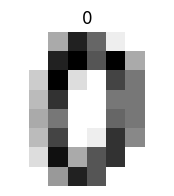

In [92]:
plt.figure(figsize=(2,2))
plt.imshow(X[0].reshape(8,8), cmap='gray_r') # gray를 반전시킨게 gray_r

plt.axis('off')
plt.title(y[0])
plt.show()

In [93]:
from sklearn.svm import SVC

model = SVC(probability=True).fit(X,y) # 기본 파라미터로 모형 생성

In [95]:
test_x = X[0].reshape(1, -1)
print('예측 :', model.predict(test_x), '/ 실제 :', y[0] )

예측 : [0] / 실제 : 0


In [100]:
prob = model.predict_proba(test_x)[0]
classes = model.classes_
# print('분류 :', classes)
# print('확률 :', prob)

for c, p in zip(classes, prob):
    print('{}일 확률은 : {:.3f}%'.format(c,p*100))

0일 확률은 : 99.090%
1일 확률은 : 0.020%
2일 확률은 : 0.050%
3일 확률은 : 0.091%
4일 확률은 : 0.063%
5일 확률은 : 0.142%
6일 확률은 : 0.077%
7일 확률은 : 0.096%
8일 확률은 : 0.076%
9일 확률은 : 0.295%


In [101]:
# 파라미터 탐색 전 score (accuracy) 

model.score(X,y)

0.996661101836394

In [102]:
# SVC() 모형의 최적의 gamma값 탐색

# param_range = np.linspace(-6, -1, 10) # -6부터 -1까지 10개 가져와
param_range = np.logspace(-6, -1, 10) # 10의 -6승부터 10의 -1승까지 10개 가져와
param_range # gamma값의 후보군

array([1.00000000e-06, 3.59381366e-06, 1.29154967e-05, 4.64158883e-05,
       1.66810054e-04, 5.99484250e-04, 2.15443469e-03, 7.74263683e-03,
       2.78255940e-02, 1.00000000e-01])

In [103]:
%%time

from sklearn.model_selection import validation_curve
train_scores, test_scores = validation_curve(SVC(), # 예측모형
                                             X,y,   # 데이터
                                             param_name='gamma', # gamma가 크면 결정경제가 복잡. overfitting 위험
                                             param_range=param_range,
                                             cv=10, # 교차검증
                                             scoring='accuracy', # balanced_accuracy(불균형을 고려한 정확도)
                                             n_jobs=-1 # 모든코어
    
)

CPU times: total: 406 ms
Wall time: 10.2 s


In [105]:
test_scores.shape, train_scores.shape

((10, 10), (10, 10))

In [106]:
test_scores

array([[0.1       , 0.1       , 0.1       , 0.1       , 0.1       ,
        0.1       , 0.1       , 0.29608939, 0.19553073, 0.19553073],
       [0.67777778, 0.74444444, 0.7       , 0.66666667, 0.73333333,
        0.67222222, 0.72222222, 0.70949721, 0.67597765, 0.73743017],
       [0.87777778, 0.95      , 0.90555556, 0.86666667, 0.92222222,
        0.91666667, 0.96666667, 0.93854749, 0.83240223, 0.91061453],
       [0.92222222, 0.96666667, 0.95      , 0.91111111, 0.95      ,
        0.98333333, 0.97777778, 0.96648045, 0.87709497, 0.92178771],
       [0.93888889, 0.97222222, 0.93333333, 0.95      , 0.97222222,
        0.98888889, 0.98333333, 0.99441341, 0.91061453, 0.94413408],
       [0.95555556, 1.        , 0.93333333, 0.96666667, 0.98888889,
        0.98888889, 0.99444444, 0.99441341, 0.96089385, 0.96648045],
       [0.93333333, 0.98888889, 0.95555556, 0.96666667, 0.98333333,
        0.98888889, 0.99444444, 0.99441341, 0.97765363, 0.96648045],
       [0.77777778, 0.89444444, 0.7611111

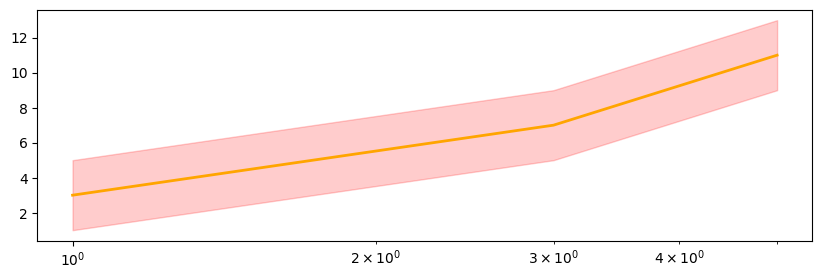

In [108]:
a = np.array([1,3,5]) # 10의1승, 10의 3승, 10의 5승
b = np.array([3,7,11]) # 3, 7, 11
plt.figure(figsize=(10,3))
plt.semilogx(a,b, color='orange', lw=2)
plt.fill_between(a, b-2, b+2, color='red', alpha=0.2)

plt.show()

In [109]:
train_scores_mean = np.mean(train_scores, axis=1) # train 평균
train_scores_std = np.std(train_scores, axis=1) # train 표준편차
test_scores_std = test_scores.std(axis=1) # test평균
test_scores_mean = test_scores.mean(axis=1) # test 표준편차

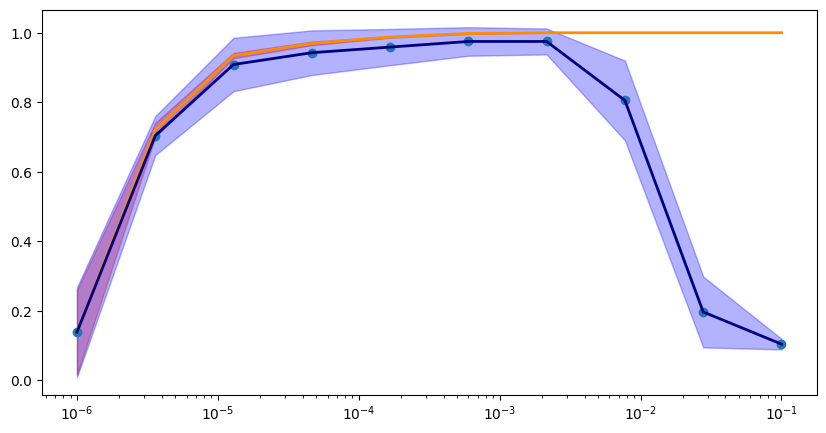

In [120]:
plt.figure(figsize=(10,5))
plt.semilogx(param_range, train_scores_mean, color='darkorange', lw=2)
plt.fill_between(param_range, 
                 train_scores_mean-train_scores_std*2,
                 train_scores_mean+train_scores_std*2,
                 alpha=0.3,
                 color='red')

plt.semilogx(param_range, test_scores_mean, color='navy', lw=2)
plt.fill_between(param_range, 
                 test_scores_mean-test_scores_std*2,
                 test_scores_mean+test_scores_std*2, # x2를 하는 이유는 표준편차 *2는 데이터의 95%를 차지하기때문
                 alpha=0.3,
                 color='blue')

plt.scatter(param_range, test_scores_mean)

plt.show()

In [121]:
test_scores_mean.argmax() # 제일 높은값 return

6

In [123]:
# 최적의 gamma값

gamma = param_range[test_scores_mean.argmax()]
gamma

0.0021544346900318843

In [125]:
model = SVC(gamma=gamma).fit(X,y)

In [126]:
model.score(X,y)

1.0

## 2-2 GridSearchCV

- 복수 하이퍼파라미터 최적화 클래스
- 모형 클래스를 가지고 있음
- fit() / predict() / score() / predict_proba() / predict_log_proba()

In [127]:
import pandas as pd

redwine = pd.read_csv('data/winequality-red.csv', sep=';')
redwine_X = redwine.iloc[:, :-1]
redwine_y = redwine.iloc[:, -1]
redwine_X.shape, redwine_y.shape

((1599, 11), (1599,))

In [128]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest

In [129]:
%%time
# 가장 평가점수가 높은 독립변수 ?개 선택, SVC()모형의 최적 C=?

selection = SelectKBest(k=1) # 가장 평가점수가 높은 k개를 찾음
svc = SVC(kernel='linear')   # 직선으로 나누는 가장 단순한 decision_function 생성
pipeline = Pipeline([('select', selection), ('svc', svc)])
param_grid = dict(select__k = [5,6,7,8,9,10,11],
                  svc__C = [0.1,1,10]) # 크면 클수록 과적합을 허용
grid_search = GridSearchCV(pipeline, 
                           param_grid=param_grid, # 파라미터들
                           cv=2, # 교차검증 k-fold cross validation
                           verbose=2, # 로그출력
                           n_jobs=-1)
grid_search.fit(redwine_X, redwine_y)

Fitting 2 folds for each of 21 candidates, totalling 42 fits
CPU times: total: 13 s
Wall time: 1min 32s


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('select', SelectKBest(k=1)),
                                       ('svc', SVC(kernel='linear'))]),
             n_jobs=-1,
             param_grid={'select__k': [5, 6, 7, 8, 9, 10, 11],
                         'svc__C': [0.1, 1, 10]},
             verbose=2)

In [130]:
print(grid_search.best_estimator_) # 가장 높은 점수를 낸 파라미터 모형

Pipeline(steps=[('select', SelectKBest(k=9)),
                ('svc', SVC(C=1, kernel='linear'))])


In [131]:
print(grid_search.best_params_) # 최적의 파라미터 정보

{'select__k': 9, 'svc__C': 1}


In [132]:
model = grid_search.best_estimator_
model.predict(redwine_X)

array([5, 5, 5, ..., 6, 5, 6], dtype=int64)

In [133]:
# 최적의 k값과 C값의 model

model.score(redwine_X, redwine_y)

0.5872420262664165

In [135]:
# 기본 SVC model

model = SVC().fit(redwine_X, redwine_y)
model.score(redwine_X, redwine_y)

0.5103189493433395

# 3절. 자료 불균형 처리

- 단순 오버/언더 샘플링
- 단, 단순 오버샘플시 소수의 데이터를 복사하면 그 데이터에 의해 과적합이 생길 수 있음
- SMOTE 라이브러리를 이용한 오버샘플링

## 3-1 SMOTE를 이용한 오버샘플링

In [139]:
# 데이터 (99:1)

from sklearn.datasets import make_classification

X,y = make_classification(n_samples=10000, # 데이터수
                          n_features=10,   # 독립변수 갯수
                          n_informative=5, # 종속변수에 영향을 주는 갯수 
                          n_redundant=0,   # 독립변수들끼리 상관관계가 있는게 없다
                          n_clusters_per_class=1, # 클래스당 서브 클러스터 수(서브 클래스가 없다)
                          n_classes=2,
                          weights=[0.99, 0.01], # 각 클래스의 할당된 표본 확률
                          random_state=42)
X.shape, y.shape, y.sum()

((10000, 10), (10000,), 140)

In [141]:
# train - test 셋 분리 → SMOTE(train데이터만) → 모델 fit(train데이터) → score(test데이터)
# train - test 셋 분리

X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size=0.3,
                                                    stratify=y,
                                                    random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((7000, 10), (7000,), (3000, 10), (3000,))

In [143]:
print(y_train.mean()) # 1이 1.4%
pd.Series(y_train).value_counts()

0.014


0    6902
1      98
dtype: int64

In [144]:
# SMOTE(train데이터만)
# pip install imbalanced-learn==0.10.1

from imblearn.over_sampling import SMOTE

# sm = SMOTE(sampling_strategy={0:6902, 1:600}) 양심의 가책을 느낄때
sm = SMOTE()
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)

In [145]:
pd.Series(y_resampled).value_counts()

0    6902
1    6902
dtype: int64

## 3-2 가중치 제어 모형

- 자료 불균형 처리의 또 다른 방법
- 데이터에 따른 가중치를 모델에 부여 방법

In [146]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100,
                                  class_weight={0:1, 1:1.5}, # 가중치 부여 (1클래스에 조금 더 주겠다)
                                  random_state=42)

rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 1, 1: 1.5}, random_state=42)

# 4절. 앙상블 모형

- 목적 : 여러개 분류 모델을 하나의 통합 분류 모델로 연결하여 개별 분류 모델보다 더 좋은 성능 달성
- 방법 :
    - 배깅(bagging) : 분류를 잘하는 모델에 가중치 (병렬작업) ex.RandomForest
    - 부스팅(boosting) : 분류가 안된 데이터에 가중치 (순차작업) ex. XGBoost, LGBM, AdaBoost - 불균형 데이터
    - 투표(Voting) : 여러개 모델의 다수결 투표

cf. 배깅 알고리즘시 0.632 규칙 : 복원추출시 63.2% 추출 

In [153]:
np.random.choice(10, 10, replace=True) # 복원추출로 10미만의 수를 10개 추출

array([3, 8, 2, 6, 8, 5, 3, 6, 1, 2])

In [154]:
# 10 미만의 수 10개 복원추출할 경우 뽑히는 수의 갯수

len(set(np.random.choice(10, 10, replace=True)))

7

In [171]:
# 1000 미만의 수 1000개 복원추출할 경우 뽑히는 수의 갯수

len(set(np.random.choice(1000, 1000, replace=True)))

634

In [179]:
# n 미만의 수 n개를 복원추출할 경우의 데이터 %

n = 100000
len(set(np.random.choice(n, n, replace=True)))/n

0.63284

In [180]:
# 데이터

from sklearn.datasets import make_classification

X,y = make_classification(n_samples=10000,
                          n_features=10,
                          n_informative=5,
                          n_redundant=0,
                          n_clusters_per_class=1,
                          n_classes=2,
                          weights=[0.9,0.1],
                          random_state=42)

In [181]:
train_X, test_X, train_y, test_y = train_test_split(X,y,
                                                    test_size=0.3,
                                                    stratify=y,
                                                    random_state=42)
sm = SMOTE()
resampled_X, resampled_y = sm.fit_resample(train_X, train_y)
resampled_X.shape, resampled_y.shape

((12556, 10), (12556,))

In [189]:
from sklearn.metrics import precision_score, recall_score, f1_score

def model_measure(model, train_X=resampled_X, train_y=resampled_y, 
                  test_X=test_X, test_y=test_y):
    model.fit(train_X, train_y)
    accuracy = model.score(test_X, test_y)
    hat_y = model.predict(test_X)
    precision = precision_score(test_y, hat_y)
    recall    = recall_score(test_y, hat_y)
    f1 = f1_score(test_y, hat_y)
    print(f"정확도 :{accuracy:.4f} / precision:{precision:.4f} / recall:{recall:.4f} / f1:{f1:.4f}")

## 4-1 배깅

- RandomForestClassifier, BaggingClassifier

In [190]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100,
                               random_state=42)
model_measure(model)

정확도 :0.9823 / precision:0.9324 / recall:0.8932 / f1:0.9124


In [191]:
from sklearn.ensemble import BaggingClassifier

model_measure(BaggingClassifier(n_estimators=200, bootstrap=True)) # 복원추출

정확도 :0.9767 / precision:0.8842 / recall:0.8900 / f1:0.8871


## 4-2 부스팅

- AdaBoost, XGB, LIghtGBM, GradiantBoost, CatBoost

In [198]:
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [193]:
model_measure(AdaBoostClassifier())

정확도 :0.9540 / precision:0.7198 / recall:0.9061 / f1:0.8023


In [194]:
model_measure(XGBClassifier())

정확도 :0.9867 / precision:0.9590 / recall:0.9094 / f1:0.9336


In [197]:
model_measure(LGBMClassifier(force_col_wise=True))

[LightGBM] [Info] Number of positive: 6278, number of negative: 6278
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 12556, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
정확도 :0.9863 / precision:0.9527 / recall:0.9126 / f1:0.9322


In [199]:
model_measure(CatBoostClassifier())

Learning rate set to 0.030349
0:	learn: 0.6497741	total: 6.77ms	remaining: 6.77s
1:	learn: 0.6084778	total: 12.8ms	remaining: 6.38s
2:	learn: 0.5728492	total: 19.4ms	remaining: 6.45s
3:	learn: 0.5359723	total: 26.3ms	remaining: 6.54s
4:	learn: 0.5033473	total: 33ms	remaining: 6.57s
5:	learn: 0.4697009	total: 43.6ms	remaining: 7.22s
6:	learn: 0.4436048	total: 51.6ms	remaining: 7.32s
7:	learn: 0.4182557	total: 58.9ms	remaining: 7.3s
8:	learn: 0.3980091	total: 66.6ms	remaining: 7.34s
9:	learn: 0.3791863	total: 73.4ms	remaining: 7.26s
10:	learn: 0.3604649	total: 79.8ms	remaining: 7.17s
11:	learn: 0.3413149	total: 86.8ms	remaining: 7.15s
12:	learn: 0.3242847	total: 93.4ms	remaining: 7.09s
13:	learn: 0.3113049	total: 101ms	remaining: 7.11s
14:	learn: 0.2988067	total: 108ms	remaining: 7.07s
15:	learn: 0.2870580	total: 114ms	remaining: 7.03s
16:	learn: 0.2754717	total: 121ms	remaining: 7.02s
17:	learn: 0.2633499	total: 128ms	remaining: 6.96s
18:	learn: 0.2545914	total: 135ms	remaining: 6.96s
1

181:	learn: 0.0606086	total: 1.25s	remaining: 5.62s
182:	learn: 0.0602253	total: 1.26s	remaining: 5.61s
183:	learn: 0.0599636	total: 1.26s	remaining: 5.6s
184:	learn: 0.0597179	total: 1.27s	remaining: 5.6s
185:	learn: 0.0594045	total: 1.28s	remaining: 5.58s
186:	learn: 0.0592199	total: 1.28s	remaining: 5.58s
187:	learn: 0.0590587	total: 1.29s	remaining: 5.57s
188:	learn: 0.0588270	total: 1.29s	remaining: 5.56s
189:	learn: 0.0585902	total: 1.3s	remaining: 5.55s
190:	learn: 0.0583079	total: 1.31s	remaining: 5.54s
191:	learn: 0.0581048	total: 1.31s	remaining: 5.53s
192:	learn: 0.0579632	total: 1.32s	remaining: 5.52s
193:	learn: 0.0577363	total: 1.33s	remaining: 5.51s
194:	learn: 0.0576003	total: 1.33s	remaining: 5.5s
195:	learn: 0.0572420	total: 1.34s	remaining: 5.5s
196:	learn: 0.0571408	total: 1.35s	remaining: 5.49s
197:	learn: 0.0569848	total: 1.35s	remaining: 5.49s
198:	learn: 0.0568449	total: 1.36s	remaining: 5.48s
199:	learn: 0.0566677	total: 1.37s	remaining: 5.47s
200:	learn: 0.056

364:	learn: 0.0339726	total: 2.51s	remaining: 4.36s
365:	learn: 0.0338180	total: 2.52s	remaining: 4.36s
366:	learn: 0.0337680	total: 2.52s	remaining: 4.35s
367:	learn: 0.0336926	total: 2.53s	remaining: 4.34s
368:	learn: 0.0336498	total: 2.54s	remaining: 4.34s
369:	learn: 0.0335589	total: 2.54s	remaining: 4.33s
370:	learn: 0.0334230	total: 2.55s	remaining: 4.32s
371:	learn: 0.0333307	total: 2.56s	remaining: 4.32s
372:	learn: 0.0332368	total: 2.56s	remaining: 4.31s
373:	learn: 0.0331173	total: 2.57s	remaining: 4.3s
374:	learn: 0.0330061	total: 2.58s	remaining: 4.3s
375:	learn: 0.0329293	total: 2.58s	remaining: 4.29s
376:	learn: 0.0328430	total: 2.59s	remaining: 4.28s
377:	learn: 0.0327201	total: 2.6s	remaining: 4.27s
378:	learn: 0.0326575	total: 2.6s	remaining: 4.26s
379:	learn: 0.0325510	total: 2.61s	remaining: 4.26s
380:	learn: 0.0324259	total: 2.62s	remaining: 4.25s
381:	learn: 0.0323292	total: 2.62s	remaining: 4.24s
382:	learn: 0.0322151	total: 2.63s	remaining: 4.23s
383:	learn: 0.03

545:	learn: 0.0212273	total: 3.77s	remaining: 3.13s
546:	learn: 0.0211768	total: 3.77s	remaining: 3.12s
547:	learn: 0.0210865	total: 3.78s	remaining: 3.12s
548:	learn: 0.0210696	total: 3.79s	remaining: 3.11s
549:	learn: 0.0210485	total: 3.79s	remaining: 3.1s
550:	learn: 0.0209610	total: 3.8s	remaining: 3.1s
551:	learn: 0.0209211	total: 3.81s	remaining: 3.09s
552:	learn: 0.0208690	total: 3.81s	remaining: 3.08s
553:	learn: 0.0208085	total: 3.82s	remaining: 3.08s
554:	learn: 0.0207565	total: 3.83s	remaining: 3.07s
555:	learn: 0.0206645	total: 3.84s	remaining: 3.06s
556:	learn: 0.0206108	total: 3.84s	remaining: 3.06s
557:	learn: 0.0205554	total: 3.85s	remaining: 3.05s
558:	learn: 0.0204988	total: 3.86s	remaining: 3.04s
559:	learn: 0.0204531	total: 3.87s	remaining: 3.04s
560:	learn: 0.0204324	total: 3.87s	remaining: 3.03s
561:	learn: 0.0203837	total: 3.88s	remaining: 3.02s
562:	learn: 0.0203586	total: 3.89s	remaining: 3.02s
563:	learn: 0.0203288	total: 3.89s	remaining: 3.01s
564:	learn: 0.0

730:	learn: 0.0141221	total: 5.02s	remaining: 1.85s
731:	learn: 0.0140935	total: 5.03s	remaining: 1.84s
732:	learn: 0.0140762	total: 5.03s	remaining: 1.83s
733:	learn: 0.0140451	total: 5.04s	remaining: 1.83s
734:	learn: 0.0140084	total: 5.05s	remaining: 1.82s
735:	learn: 0.0139674	total: 5.05s	remaining: 1.81s
736:	learn: 0.0139222	total: 5.06s	remaining: 1.8s
737:	learn: 0.0138823	total: 5.07s	remaining: 1.8s
738:	learn: 0.0138474	total: 5.07s	remaining: 1.79s
739:	learn: 0.0138255	total: 5.08s	remaining: 1.78s
740:	learn: 0.0138182	total: 5.09s	remaining: 1.78s
741:	learn: 0.0138007	total: 5.09s	remaining: 1.77s
742:	learn: 0.0137904	total: 5.1s	remaining: 1.76s
743:	learn: 0.0137568	total: 5.11s	remaining: 1.76s
744:	learn: 0.0137210	total: 5.11s	remaining: 1.75s
745:	learn: 0.0136889	total: 5.12s	remaining: 1.74s
746:	learn: 0.0136469	total: 5.13s	remaining: 1.74s
747:	learn: 0.0135967	total: 5.13s	remaining: 1.73s
748:	learn: 0.0135847	total: 5.14s	remaining: 1.72s
749:	learn: 0.0

921:	learn: 0.0099756	total: 6.28s	remaining: 531ms
922:	learn: 0.0099523	total: 6.29s	remaining: 524ms
923:	learn: 0.0099290	total: 6.29s	remaining: 518ms
924:	learn: 0.0099189	total: 6.3s	remaining: 511ms
925:	learn: 0.0099104	total: 6.31s	remaining: 504ms
926:	learn: 0.0098906	total: 6.31s	remaining: 497ms
927:	learn: 0.0098668	total: 6.32s	remaining: 490ms
928:	learn: 0.0098259	total: 6.33s	remaining: 483ms
929:	learn: 0.0098106	total: 6.33s	remaining: 477ms
930:	learn: 0.0098027	total: 6.34s	remaining: 470ms
931:	learn: 0.0097782	total: 6.34s	remaining: 463ms
932:	learn: 0.0097697	total: 6.35s	remaining: 456ms
933:	learn: 0.0097541	total: 6.36s	remaining: 449ms
934:	learn: 0.0097237	total: 6.36s	remaining: 442ms
935:	learn: 0.0097137	total: 6.37s	remaining: 435ms
936:	learn: 0.0097080	total: 6.38s	remaining: 429ms
937:	learn: 0.0096942	total: 6.38s	remaining: 422ms
938:	learn: 0.0096612	total: 6.39s	remaining: 415ms
939:	learn: 0.0096424	total: 6.39s	remaining: 408ms
940:	learn: 0